In [1]:
import time
from juliacall import Main as jl
import numpy as np
import matplotlib.pyplot as plt

# Set up Julia
jl.seval("using Pkg")
jl.Pkg.activate("../julia")
jl.Pkg.status()
jl.seval("using weighted_biot_savart_integrator")
jl.seval("using vortex_paths")

/home/crashoverride/miniforge3/envs/2024_05_work/lib/python3.12/site-packages/juliacall/__init__.py:237: UserWarning: Julia was started with multiple threads but multithreading support is experimental in JuliaCall. It is recommended to restart Python with the environment variable PYTHON_JULIACALL_HANDLE_SIGNALS=yes set, otherwise you may experience segfaults or other crashes. Note however that this interferes with Python's own signal handling, so for example Ctrl-C will not raise KeyboardInterrupt. See https://juliapy.github.io/PythonCall.jl/stable/faq/#Is-PythonCall/JuliaCall-thread-safe? for further information. You can suppress this warning by setting PYTHON_JULIACALL_HANDLE_SIGNALS=no.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `~/Dropbox/code/vorpy/julia`


Status `~/Dropbox/code/vorpy/julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.5.0
  [052768ef] CUDA v5.4.3
  [91a5bcdd] Plots v1.40.7
  [90137ffa] StaticArrays v1.9.7
  [6f5b6349] vortex_paths v0.1.0 `src/vortex_paths`
  [074c469c] weighted_biot_savart_integrator v0.1.0 `src/weighted_biot_savart_integrator`


In [2]:
def lamb_oseen_test(linelength, numsegments, dtyp, crad=5, circ=1):
    vppF = np.array([linelength/2, 0.0, 0.0], dtype=dtyp)
    vppI = -vppF.copy()
    vpps = np.linspace(vppI, vppF, numsegments+1, dtype=dtyp)
    crads = np.ones(numsegments+1, dtype=dtyp) * dtyp(crad)
    circs = np.ones(numsegments+1, dtype=dtyp) * dtyp(circ)
    
    NUMFPS = 100
    fps = np.zeros((NUMFPS, 3), dtype=dtyp)
    fps[:, 0] = dtyp(0)
    fps[:, 1] = np.linspace(1, 45, NUMFPS, dtype=dtyp)
    STEPSCALAR = dtyp(1e-6)
    MINSTEPSIZE = dtyp(1e-2)

    t0 = time.time_ns()  # TIMING
    rtnvals = jl.wbs_cpu(fps.T,
                         vpps.T,
                         crads,
                         circs,
                         stepsizescalar=STEPSCALAR,
                         minstepsize=MINSTEPSIZE,
                         threaded=True)

    t1 = time.time_ns()  # TIMING

    anavelsinf = np.zeros((NUMFPS, 3), dtype=dtyp)
    anavelspoly = np.zeros((NUMFPS, 3), dtype=dtyp)
    for i in range(NUMFPS):
        anavelsinf[i] = jl.u_inflong_line(fps[i], vppI, vppF, crads[1], circs[1])
        anavelspoly[i] = jl.u_polyline(fps[i], vpps.T, circs)

    # errinf = np.abs(anavelsinf[:, 2] - rtnvals.to_numpy().T[:, 2])
    # errpoly = np.abs(anavelspoly[:, 2] - rtnvals.to_numpy().T[:, 2])

    return rtnvals.to_numpy().T, anavelsinf, anavelspoly, t1 - t0, fps
    # return rtnvals.to_numpy().T, errinf, errpoly, t1 - t0, fps

In [5]:
# Run once (to compile?)
rtn1 = lamb_oseen_test(10_000, 10_000, np.float64, crad=5, circ=1)
print('len(rtn1):', len(rtn1))
print('Time (ms):', rtn1[3]/1e6)

len(rtn1): 5
Time (ms): 377.131521


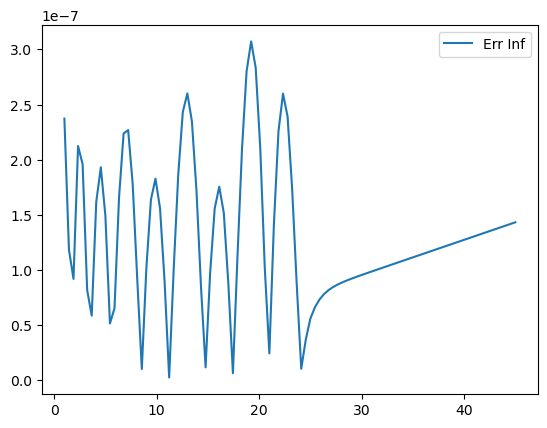

In [6]:
# print(rtn1[0][:, 2])
# print(rtn1[1][:, 2])
# print(rtn1[2][:, 2])

# plt.plot(rtn1[4][:, 1], rtn1[1][:, 2], 'x-', label='Analytical')
# plt.plot(rtn1[4][:, 1], rtn1[0][:, 2], label='WBS')
# plt.legend()
# plt.show()

errinf = np.abs(rtn1[0][:, 2] - rtn1[1][:, 2])
# errpoly = np.abs(rtn1[0][:, 2] - rtn1[2][:, 2])
plt.plot(rtn1[4][:, 1], errinf, label='Err Inf')
# plt.plot(rtn1[4][:, 1], errpoly, label='Err Poly')
plt.legend()
# plt.ylim(0, 1e-6)
plt.show()

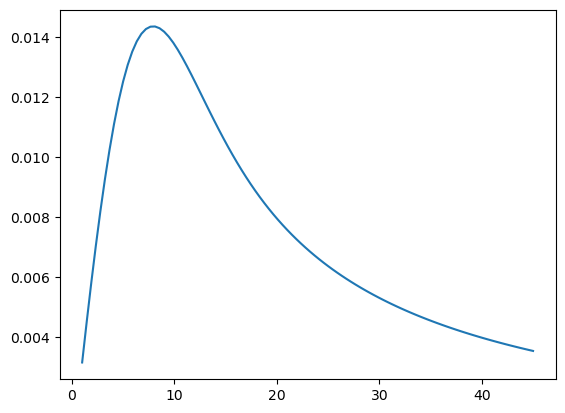

In [7]:
plt.plot(rtn1[4][:, 1], rtn1[0][:, 2])
plt.show()